In [53]:
import renderapi
import pandas as pd
import numpy as np
import json
from at_synapse_detection.AnnotationJsonSchema import AnnotationFile
import matplotlib.pyplot as plt
%matplotlib notebook

In [54]:
annotation_metadata = 'MNSite3Synaptograms_v2.csv'
annotation_file = 'm247514_Site3Annotation_MN_global_v2.json'
annotation_stack = 'Site3Align2_EM_multichannel'

In [55]:
example_parameters = {
    "render":{
        "host": "ibs-forrestc-ux1",
        "port": 80,
        "owner": "Forrest",
        "project": "M247514_Rorb_1",
        "client_scripts": "/pipeline/allenrender/render-ws-java-client/src/main/scripts"
    }
}

In [56]:
render = renderapi.connect(**example_parameters['render'])

In [57]:
df = pd.read_csv(annotation_metadata,index_col=0)

In [58]:
df[df.minX==np.min(df.minX)]

,Nz,figure,height,id,maxX,maxY,maxZ,minX,minY,minZ,...,ConsensusNotSynapse,PossibleNotSynapse,ReCheckMF,nofigure,recheck_merge,edgesynapse,enface synapse,PSD positive,comments FC,comments MN
6,,NaN,1384.197553,6,8202.0,7457.0,22,4660.609974,6073.802448,3,...,1,0,0,True,done,NaN,NaN,NaN,NaN,NaN


In [59]:
good_rows = (df['ConsensusNotSynapse']==False) & (df['pregaba(F)']==False)

In [60]:
np.sum(good_rows)

803

In [61]:
good_df=df[good_rows]
good_df['minZ']+=1
good_df['maxZ']-=1

/Users/forrestc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/forrestc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
def load_annotation_file(annotation_path):
    with open(annotation_path,'r') as fp:
            annotation_d = json.load(fp)
    schema = AnnotationFile()
    annotations,errors = schema.load(annotation_d)        
    assert(len(errors)==0)
    return annotations

In [63]:
annotations = load_annotation_file(annotation_file)

In [64]:
#bounds = renderapi.stack.get_stack_bounds(annotation_stack,render=render)
#img = renderapi.image.get_bb_image(annotation_stack,25,bounds['minX'],bounds['minY'],bounds['maxX']-bounds['minX'],
#                                  bounds['maxY']-bounds['minY'],0.25,render=render)


In [65]:
import seaborn as sns

In [66]:
# f,ax = plt.subplots(1,1,figsize=(20,20))
# ax.imshow(img,extent=[bounds['minX'],bounds['maxX'],bounds['maxY'],bounds['minY']],cmap=plt.cm.gray)
# Ncolors = 50
# colors=sns.color_palette("bright", Ncolors)
# for i,al in enumerate(annotations['area_lists']):
    
#     if al['id'] in good_df.index:
#         for area in al['areas']:
#             if int(area['z'])==25:
#             #ax.plot(area['global_path'][:,0],area['global_path'][:,1],c=colors[i%Ncolors])
#                 poly= plt.Polygon(area['global_path'],color=colors[i%Ncolors],fill=True)
#                 ax.add_artist(poly)
# ax.set_aspect('equal')
# ax.set_xticks([])
# ax.set_yticks([])


In [67]:
#f.savefig('test7.eps')

In [68]:
MNglut_annotations = [al for al in annotations['area_lists'] if al['id'] in good_df.index]

In [185]:
ann_minX=good_df.min().minX
ann_minY=good_df.min().minY
ann_maxX=good_df.max().maxX
ann_maxY=good_df.max().maxY
ann_minZ=good_df.min().minZ
ann_maxZ=good_df.max().maxZ

In [187]:
ann_maxZ

50

In [70]:
ann_width = int(ann_maxX - ann_minX)
ann_height = int(ann_maxY - ann_minY)
ann_depth = 50

In [71]:
ds_scale = 3.0/100.0

In [72]:
ann_ds_width = int(ann_width*ds_scale)
ann_ds_height = int(ann_height*ds_scale)
ann_ds_depth = 50


In [151]:
import cv2
ann_volume = np.zeros((ann_depth,ann_height,ann_width),np.uint32)
for al in MNglut_annotations:
    for area in al['areas']:
        gp = np.copy(area['global_path'])
        #gp[:,0]-=ann_minX
        #gp[:,1]-=ann_minY
        gp=np.int32(gp)
        z= int(area['z'])
        
        row = good_df.loc[al['id']]
        
        gp[:,0]-=int(row.minX)
        gp[:,1]-=int(row.minY)
        minY = int(row.minY-ann_minY)
        maxY = int(row.maxY-ann_minY)
        minX = int(row.minX-ann_minX)
        maxX = int(row.maxX-ann_minX)
        z = int(int(area['z'])-0)
        lH = int(maxY - minY)
        lW = int(maxX - minX)

        local_annotation = np.zeros((lH,lW),np.uint8)
        cv2.fillPoly(local_annotation,[np.int64(gp)],1)
        ann_volume[z,minY:maxY,minX:maxX]*=(1-local_annotation)
        ann_volume[z,minY:maxY,minX:maxX]+=np.uint32(local_annotation)*int(al['oid'])
        
        #cv2.fillPoly(ann_volume[z,:,:],[gp],np.uint16(al['oid']))
   

<IPython.core.display.Javascript object>


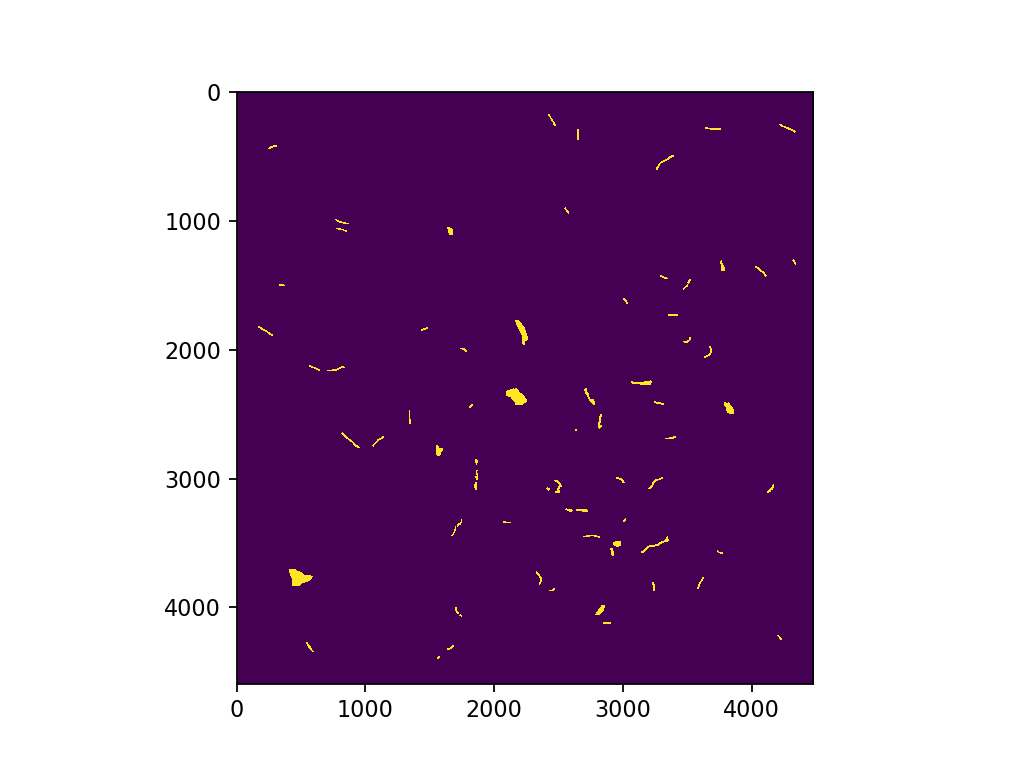

In [74]:
plt.figure()
plt.imshow(ann_volume[z,:,:],vmax=10)

In [75]:
ann_volume.shape,z,np.min(gp,axis=0)

((50, 4592, 4476), 8, array([144, 135], dtype=int32))

<IPython.core.display.Javascript object>


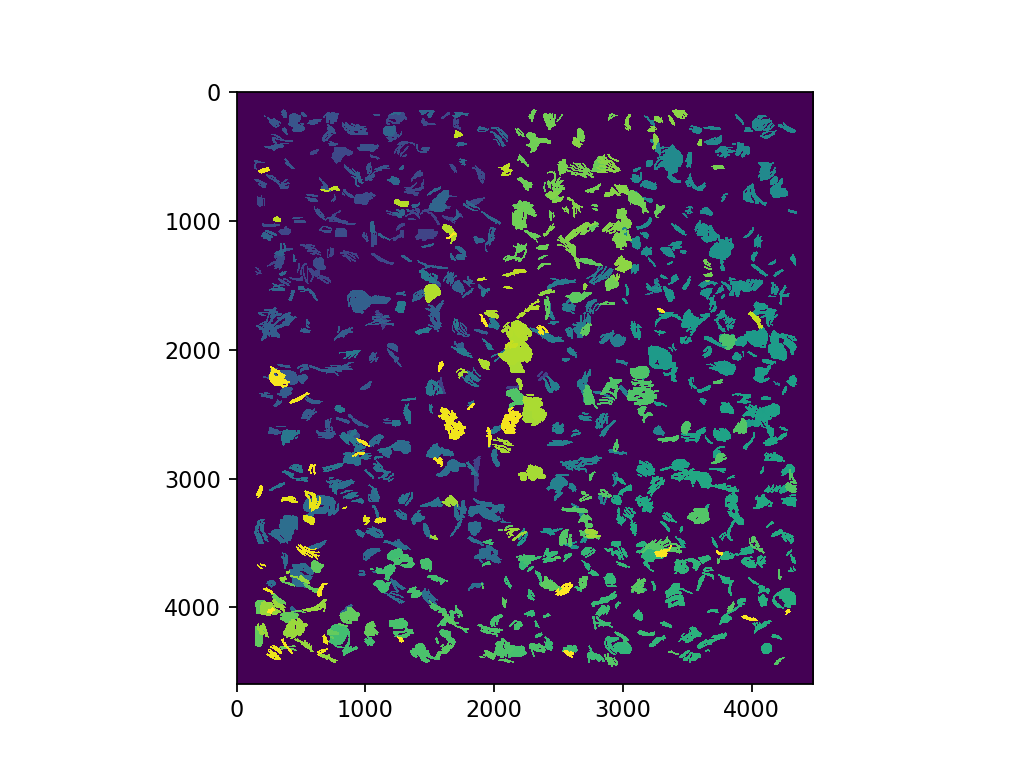

In [23]:
f,ax = plt.subplots()
ax.imshow(np.max(ann_volume,axis=0))

In [76]:
import tifffile
import os

In [77]:
#tifffile.imsave('test_ann3.tif',ann_volume)

In [78]:
import tifffile
lm_bounds = (0,14021,0,14724)
lm_minX,lm_maxX,lm_minY,lm_maxY = lm_bounds


image_stack_dir = '.'
channels= [f for f in os.listdir(image_stack_dir) if os.path.isdir(f) and not f.startswith('.')]


In [79]:
channels

['synapsin',
 'PSD95',
 'TdTomato',
 'VGlut1',
 'GABA',
 'GluN1',
 'Gephyrin',
 'DAPI1']

In [80]:
import skimage
from scipy import ndimage
from skimage import measure

In [81]:
Z=50
psd_dir = os.path.join(image_stack_dir,'PSD95')
psd_files = [os.path.join(psd_dir,f) for f in os.listdir(psd_dir)]
img = tifffile.imread(psd_files[0])
N,M = img.shape
psdvol = np.zeros((Z,N,M),img.dtype)
for f in psd_files:
    z=int(os.path.splitext(os.path.split(f)[1])[0])
    psdvol[z,:,:]=tifffile.imread(f)

In [82]:
psdvol.shape

(50, 441, 420)

In [264]:
#nomads_file = 'NOMADS_primary_results.tiff'
#psdthresh = tifffile.imread(nomads_file)
psdthresh=psdvol>1200
synlabel,Nlabels=ndimage.label(psdthresh)
props=measure.regionprops(synlabel,psdvol)


In [411]:
LM_annotations = load_annotation_file("/Users/forrestc/SynapseAnalysis/data/M247514_Rorb_1/Site3Align2/results/resultVol0.json")
LM_annotations=LM_annotations['area_lists']

In [412]:
def coor_in_range(coors,minX,minY,maxX,maxY):
    cmin = np.min(coors,axis=0)
    cmax = np.max(coors,axis=0)
    good=(coors[:,1]>minY)& (coors[:,0]>minX) &(coors[:,0]<maxX) &(coors[:,1]<maxY)
    return np.sum(good)>0


    
    
    

In [413]:
def prop_to_coors(prop,ds_scale = .03):
    coors = np.flip(np.copy(prop.coords),1)

    coors[:,0:2]=coors[:,0:2]*1.0/ds_scale
    return coors

def prop_intersects_annotation(prop,al):
    coors=prop_to_coors(prop)
    zvalues = np.unique(coors[:,2])

    #print zvalues
    for z in zvalues:
        c2 = coors[coors[:,2]==z]
        for area in al['areas']:
            #print area['z']
            if int(area['z'])==z:
                in_area=measure.points_in_poly(c2[:,0:2],area['global_path'])
                if np.sum(in_area)>0:
                    return True
    return False

In [414]:
def make_prop_into_contours(prop, ds_scale, lm_minX, lm_minY):
    coors = np.flip(np.copy(prop.coords),1)
    zvalues = np.unique(coors[:,2])
    areas =[]
    for z in zvalues:
       
        c2 = coors[coors[:,2]==z]

        mins = np.min(c2,axis=0)
        maxs = np.max(c2,axis=0)
        c2 = c2 - mins
        rng = maxs-mins
        width=rng[0]+1
        height=rng[1]+1
        min_img = np.zeros((height,width),np.uint8)
        idx=np.ravel_multi_index((c2[:,1],c2[:,0]),(height,width))
        min_img_unravel = np.ravel(min_img)
        min_img_unravel[idx]=255
        min_img = np.reshape(min_img_unravel,(height,width))
        min_img_up=cv2.resize(min_img,(2*width,2*height))  
        #f,ax = plt.subplots()
        #ax.imshow(min_img_up,interpolation='nearest',extent=[mins[0],maxs[0]+1,maxs[1]+1,mins[1]])
        #ax.imshow(psdvol[z,:,:],interpolation='nearest',cmap=plt.cm.gray)
        a,cs,b = cv2.findContours(min_img_up,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        csf = []
        for c in cs:
            
            c = np.squeeze(c)
            #c+=.5
            c = .5*(np.array(c,np.float64)+.5)
            c[:,0]+=mins[0]
            c[:,1]+=mins[1]
            c = np.vstack((c,c[0,:]))
            c=c/ds_scale
            c[:,0]=c[:,0]+lm_minX
            c[:,1]=c[:,1]+lm_minY
            #ax.plot(c[:,0],c[:,1],linewidth=3)
            d={'z':z,'global_path':c}
            areas.append(d)
    d={'areas':areas,'oid':prop.label}
    return d
        
    

In [415]:
#al=make_prop_into_contours(prop, ds_scale,lm_minX,lm_minY)
def plot_area(area,ax,**kwargs):
    ax.plot(area['global_path'][:,0],area['global_path'][:,1],**kwargs)
   

In [416]:
def is_annotation_near_edge(al,ann_minX,ann_maxX,ann_minY,ann_maxY,ann_minZ,ann_maxZ,distance=100):

    boundary=geometry.Polygon(np.array([[ann_minX,ann_minY],
                                             [ann_minX,ann_maxY],
                                             [ann_maxX,ann_maxY],
                                             [ann_maxX,ann_minY]]))
    b2=boundary.buffer(distance)
    
    for area in al['areas']:
        poly1 = geometry.Polygon(area['global_path'])
        if(not b2.contains(poly1)):
            return True
    zvals=np.unique(np.array([area['z'] for area in al['areas']]))
    if len(zvals)<=3:
        if ann_minZ in zvals:
            return True
        if ann_maxZ in zvals:
            return True
        
    
    return False

In [417]:
LM_edge = np.zeros(len(LM_annotations),np.bool)
for k,al in enumerate(LM_annotations):
    LM_edge[k]=is_annotation_near_edge(al,
                                       ann_minX+200,
                                       ann_maxX-200,
                                       ann_minY+200,
                                       ann_maxY-200,
                                       ann_minZ,
                                       ann_maxZ)



In [418]:
EM_edge = np.zeros(len(MNglut_annotations),np.bool)
for k,al in enumerate(MNglut_annotations):
    EM_edge[k]=is_annotation_near_edge(al,
                                       ann_minX+200,
                                       ann_maxX-200,
                                       ann_minY+200,
                                       ann_maxY-200,
                                       ann_minZ,
                                       ann_maxZ)


In [367]:
np.sum(LM_edge),np.sum(EM_edge)

(34857, 34)

<IPython.core.display.Javascript object>


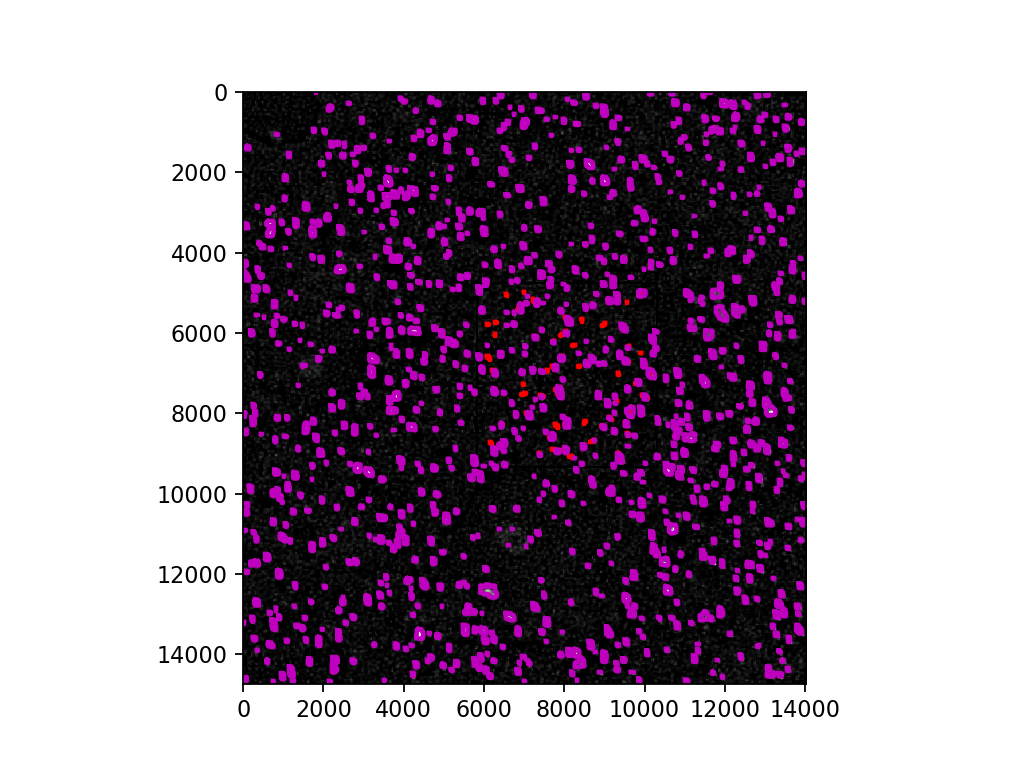

In [368]:
f,ax = plt.subplots()
zval = 25
ax.imshow(psdvol[25,:,:],
          interpolation='nearest',
          vmax=5000,
          extent = [lm_minX,lm_minX+(psdvol.shape[2]+1.0)/ds_scale,lm_minY+(psdvol.shape[1]+1.0)/ds_scale,lm_minY],
          cmap=plt.cm.gray)
ax.set_aspect('equal')
for al in MNglut_annotations:
    for area in al['areas']:
        if area['z']==zval:
            plot_area(area,ax,c='r',linewidth=2)
            
rect=plt.Rectangle((ann_minX,ann_minY),ann_width,ann_height,fill=False)
ax.add_artist(rect)
in_range_psds = []
LM_annotations = []
for i,prop in enumerate(props):
    #in_z = coors[:,2]==zval

    #if np.sum(in_z)>0:
    #    ax.scatter(coors[in_z,0],coors[in_z,1],marker='.')
    #    #ax.scatter(prop.centroid[2]/ds_scale,prop.centroid[1]/ds_scale,marker='.')
    #in_range_psds.append(i)
    al = make_prop_into_contours(prop,ds_scale,lm_minX,lm_minY)
    LM_annotations.append(al)
    for area in al['areas']:
        if area['z']==zval:
            plot_area(area,ax,c='m',linewidth=2)

<IPython.core.display.Javascript object>


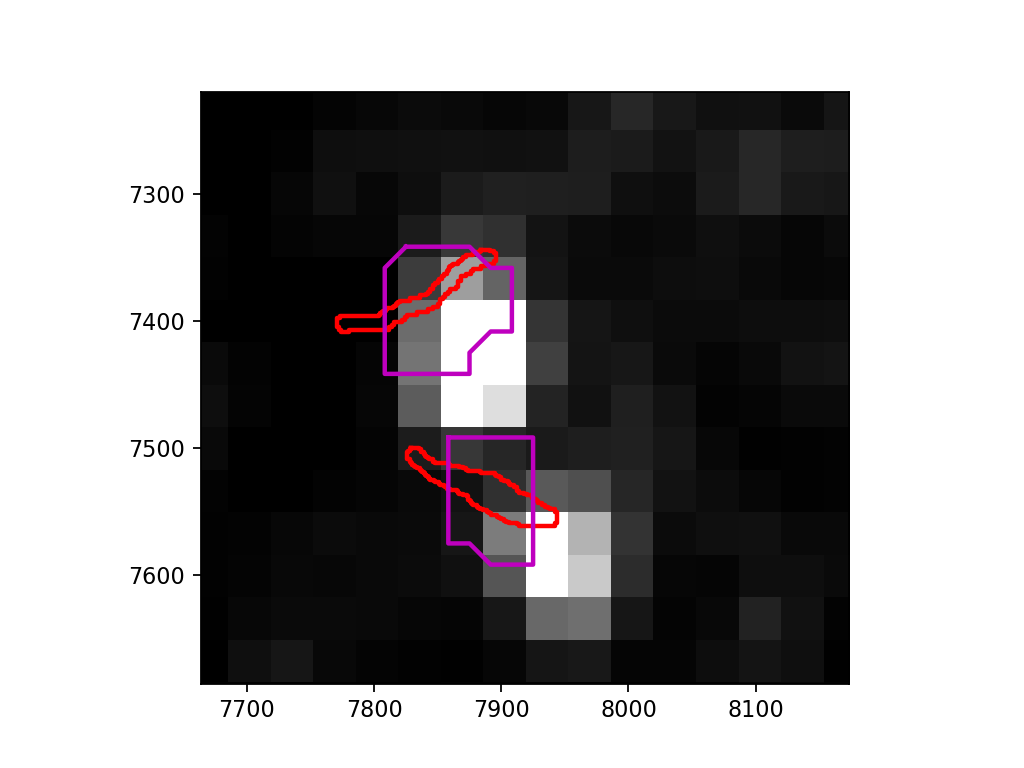

In [394]:
f,ax = plt.subplots()
zval = 25
ax.imshow(psdvol[25,:,:],
          interpolation='nearest',
          vmax=5000,
          extent = [lm_minX,lm_minX+(psdvol.shape[2]+1.0)/ds_scale,lm_minY+(psdvol.shape[1]+1.0)/ds_scale,lm_minY],
          cmap=plt.cm.gray)
ax.set_aspect('equal')
for al in MNglut_annotations:
    for area in al['areas']:
        if area['z']==zval:
            plot_area(area,ax,c='r',linewidth=2)
            
rect=plt.Rectangle((ann_minX,ann_minY),ann_width,ann_height,fill=False)
ax.add_artist(rect)
in_range_psds = []

for i,al in enumerate(LM_annotations):
    #in_z = coors[:,2]==zval

    #if np.sum(in_z)>0:
    #    ax.scatter(coors[in_z,0],coors[in_z,1],marker='.')
    #    #ax.scatter(prop.centroid[2]/ds_scale,prop.centroid[1]/ds_scale,marker='.')
    #in_range_psds.append(i)
    for area in al['areas']:
        if area['z']==zval:
            plot_area(area,ax,c='m',linewidth=2)

In [395]:
def get_bounding_box_of_al(al):
    Nareas = len(al['areas'])
    mins = np.zeros((Nareas,2))
    maxs = np.zeros((Nareas,2))
    zvalues = []
    for i,area in enumerate(al['areas']):
        gp = area['global_path']
        mins[i,:] = np.min(gp,axis=0)
        maxs[i,:] = np.max(gp,axis=0)
        zvalues.append(area['z'])
    gmin = np.min(mins,axis=0)
    gmax = np.max(maxs,axis=0)
    minX = gmin[0]
    minY = gmin[1]
    maxX = gmax[0]
    maxY = gmax[1]
    minZ = np.min(zvalues)
    maxZ = np.max(zvalues)
    return (minX,minY,minZ,maxX,maxY,maxZ)


In [396]:
import rtree

In [397]:
from rtree import index

def get_index(name='LM_index'):
    dataname = '{}.dat'.format(name)
    indexname = '{}.idx'.format(name)
    if os.path.isfile(dataname):
        os.remove(dataname)
    if os.path.isfile(indexname):
        os.remove(indexname) 
    p = index.Property()
    p.dimension=3
    return index.Index(name,properties = p)

In [398]:
LM_index=get_index('LM_index')


In [399]:
LM_bounds = []
for i,al in enumerate(LM_annotations):
    bounds = get_bounding_box_of_al(al)
    LM_bounds.append(bounds)
    #al = next(al for al in MNglut_annotations if al['id']==i)
    LM_index.insert(i,bounds)

In [400]:
EM_index = get_index('EM_index')


In [401]:
EM_bounds = []
for i,al in enumerate(MNglut_annotations):
    bounds = get_bounding_box_of_al(al)
    EM_bounds.append(bounds)
    EM_index.insert(i,bounds)

In [402]:
from shapely import geometry
def do_annotations_overlap(al1,al2):
    for area2 in al2['areas']:
        poly2 = geometry.Polygon(area2['global_path'])
        for area1 in al1['areas']:
            if int(area1['z'])==int(area2['z']):
                poly1 = geometry.Polygon(area1['global_path'])
                if poly1.intersects(poly2):
                    return True,area1['z']
    return False,None

In [403]:
 
overlap_matrix = np.zeros((len(MNglut_annotations),len(LM_annotations)),np.bool)
breakout=False
for i,alLM in enumerate(LM_annotations):
    res=EM_index.intersection(LM_bounds[i])
    for k in res:
        alEM=MNglut_annotations[k]
        overlaps,zsection = do_annotations_overlap(alLM,alEM)
        if overlaps:
            overlap_matrix[k,i]=True
#             f,ax = plt.subplots()
#             for area in alLM['areas']:
#                 if area['z']==zsection:
#                     plot_area(area,ax,c='g')
#             for area in MNglut_annotations[k]['areas']:
#                 if area['z']==zsection:
#                     plot_area(area,ax,c='r')
                
            

<IPython.core.display.Javascript object>


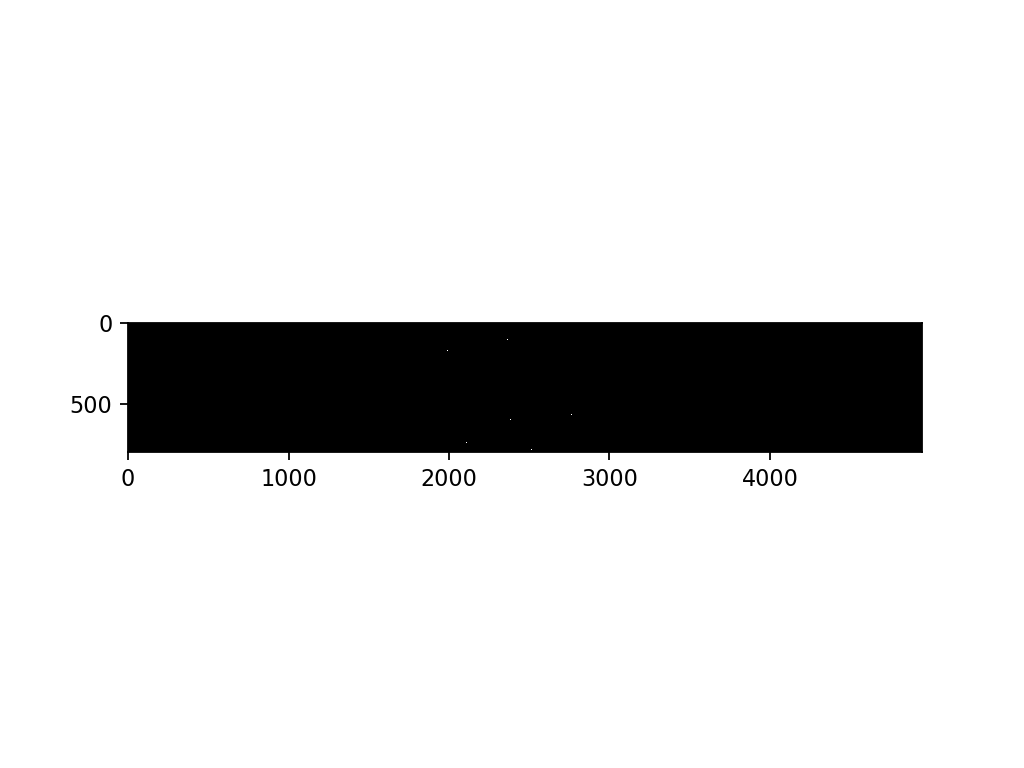

In [404]:
f,ax = plt.subplots()
ax.imshow(overlap_matrix*255,cmap=plt.cm.gray)

In [405]:
overlap_matrix.shape

(803, 4946)

In [406]:
overlap_matrix[EM_edge==False,:].shape

(769, 4946)

In [407]:
LM_per_EM = np.sum(overlap_matrix,axis=1)
EM_per_LM = np.sum(overlap_matrix,axis=0)
f,ax = plt.subplots(2,1,figsize=(7,7))
bins = np.arange(0,4)
counts,edges = np.histogram(LM_per_EM[EM_edge==False],bins=bins,normed=True)
print(counts)
ax[0].bar(edges[:-1],counts)
ax[0].set_title('LM_per_EM')
ax[0].set_xticks(bins[:-1])
counts,edges = np.histogram(EM_per_LM[LM_edge==False],bins=bins,normed=True)
print(counts)
ax[1].bar(edges[:-1],counts)
ax[1].set_title('EM_per_LM')
ax[1].set_xticks(bins[:-1])


<IPython.core.display.Javascript object>

[ 0.60807292  0.34375     0.04817708]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4946 but corresponding boolean dimension is 38208

In [382]:
import cv2
ann_volume = np.zeros((ann_depth,ann_height,ann_width),np.uint32)
missed_annotations = [al for k,al in enumerate(MNglut_annotations) if (not EM_edge[k]) and (LM_per_EM[k]==0)]
for al in missed_annotations:
    for area in al['areas']:
        gp = np.copy(area['global_path'])
        #gp[:,0]-=ann_minX
        #gp[:,1]-=ann_minY
        gp=np.int32(gp)
        z= int(area['z'])
        
        row = good_df.loc[al['id']]
        
        gp[:,0]-=int(row.minX)
        gp[:,1]-=int(row.minY)
        minY = int(row.minY-ann_minY)
        maxY = int(row.maxY-ann_minY)
        minX = int(row.minX-ann_minX)
        maxX = int(row.maxX-ann_minX)
        z = int(int(area['z'])-0)
        lH = int(maxY - minY)
        lW = int(maxX - minX)

        local_annotation = np.zeros((lH,lW),np.uint8)
        cv2.fillPoly(local_annotation,[np.int64(gp)],1)
        ann_volume[z,minY:maxY,minX:maxX]*=(1-local_annotation)
        ann_volume[z,minY:maxY,minX:maxX]+=np.uint32(local_annotation)*int(al['oid'])
        
        #cv2.fillPoly(ann_volume[z,:,:],[gp],np.uint16(al['oid']))

<IPython.core.display.Javascript object>


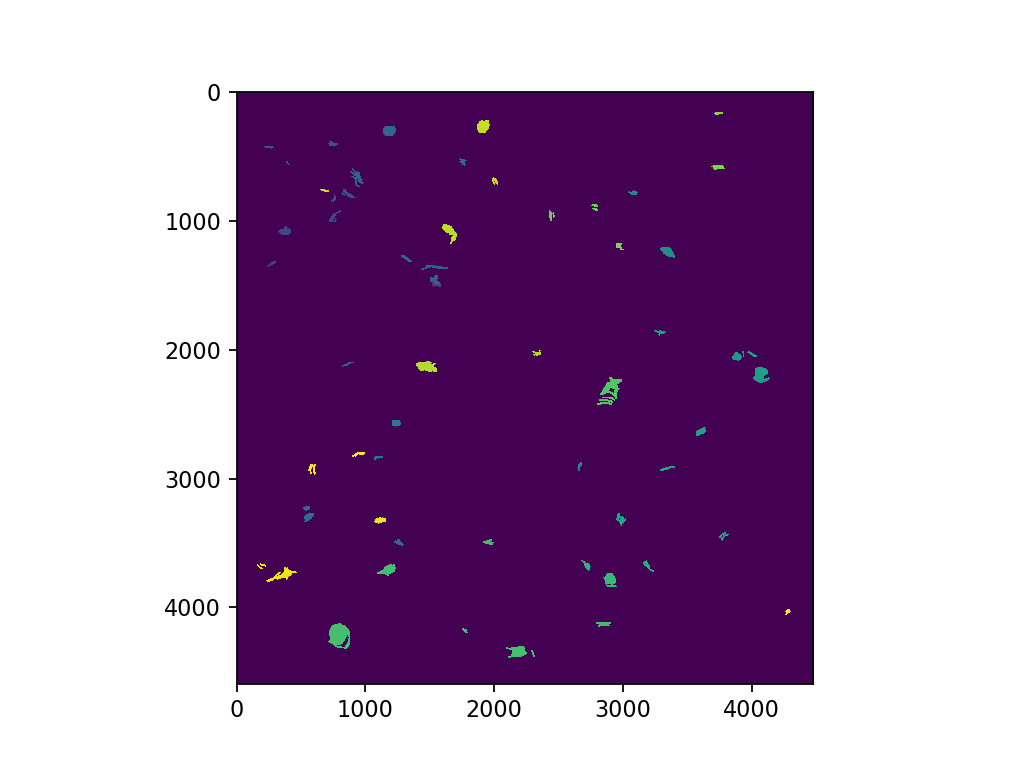

In [383]:
f,ax = plt.subplots()
ax.imshow(np.max(ann_volume,axis=0))

In [384]:
np.sum((LM_per_EM==0)&(EM_edge==False))/(1.0*len(LM_per_EM))


0.07347447073474471

In [388]:
areas = np.array([p.area for p in props])
mean_int = np.array([p.mean_intensity for p in props],np.float128)
dz = np.array([(np.max(p.coords,axis=0)-np.min(p.coords,axis=0))[0] for p in props])
centers = np.array([np.mean(p.coords,axis=0) for p in props])
fp = np.where((EM_per_LM==0)&(LM_edge==False))[0]
tp = np.where((EM_per_LM>=1)&(LM_edge==False))[0]
fpi = np.array([LM_annotations[f]['oid']-1 for f in fp])
tpi = np.array([LM_annotations[f]['oid']-1 for f in tp])
tot_int = mean_int*areas

<IPython.core.display.Javascript object>


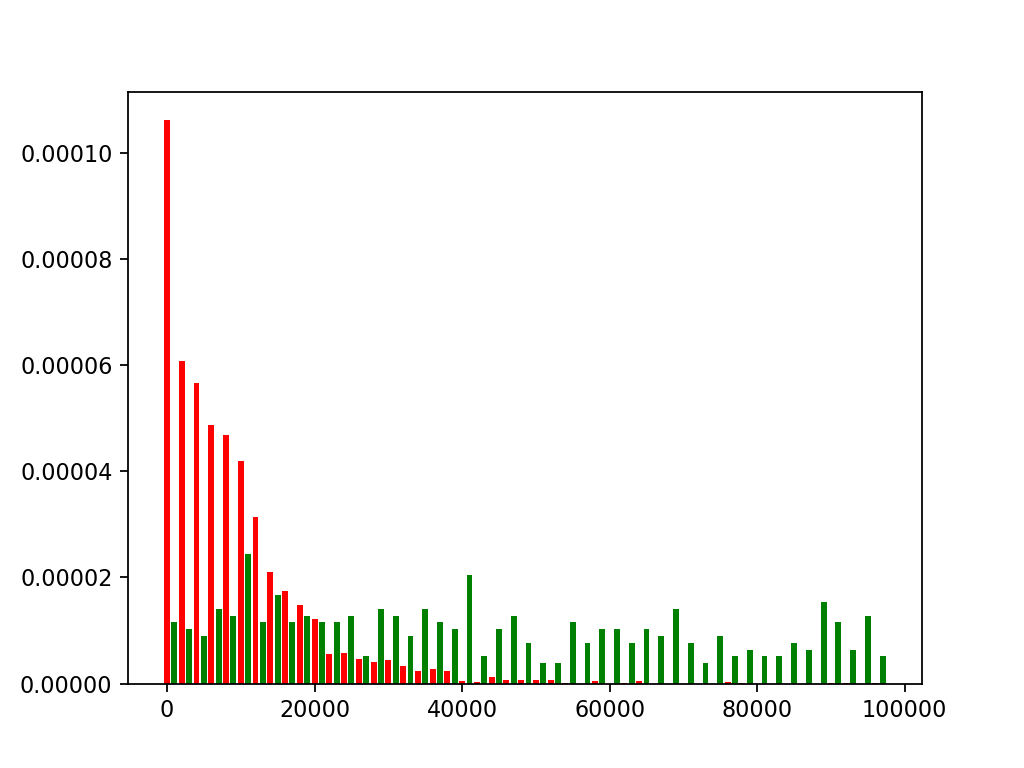

<Container object of 49 artists>

In [389]:
f,ax = plt.subplots()
max_bin = 100000.0
bin_width=max_bin/50
a,bins=np.histogram(tot_int[fpi],
                    bins=np.arange(0,max_bin,bin_width),
                    normed=True)
ax.bar(bins[:-1],a,.8*(bin_width/2),color='r')

a,bins=np.histogram(tot_int[tpi],
                    bins=np.arange(0,max_bin,bin_width),
                    normed=True)
ax.bar(bins[:-1]+(bin_width/2),a,.8*bin_width/2,color='g')
# for k in fp:
#     al = LM_annotations[k]
#     for area in al['areas']:
#         plot_area(area,ax,c='r')
# for k in tp:
#     al = LM_annotations[k]
#     for area in al['areas']:
#         plot_area(area,ax,c='g')
#ax.scatter(centers[tp,2],centers[tp,1],c='g')
#ax.scatter(centers[fp,2],centers[fp,1],c='r')

In [338]:
import neuroglancer

ng_server="http://ibs-forrestc-ux1:8001"
ng_url="http://ibs-forrestc-ux1:8001/#!{'layers':{'Site3Align2_EM_clahe_mm':{'type':'image'_'source':'render://http://ibs-forrestc-ux1:80/Forrest/M247514_Rorb_1/Site3Align2_EM_clahe_mm'}_'Site3Align2_LENS_PSD95b_deconvnew':{'type':'image'_'source':'render://http://ibs-forrestc-ux1.corp.alleninstitute.org:80/Forrest/M247514_Rorb_1/Site3Align2_LENS_PSD95b_deconvnew'_'color':1_'max':0.17}_'emseg':{'type':'segmentation'_'source':'precomputed://http://ibs-forrestc-ux1:8084/emsyn/'}}_'navigation':{'pose':{'position':{'voxelSize':[1_1_1]_'voxelCoordinates':[6150.1513671875_6850.00244140625_10]}}_'zoomFactor':1.285313547626216}}"

In [339]:
state=neuroglancer.parse_url(ng_url)

In [346]:
from IPython.core.display import display, HTML
badones= np.where((LM_per_EM==0)&(EM_edge==False))
link = ""
for ind in badones[0]:
    al=MNglut_annotations[ind]
    area = al['areas'][0]
    z=area['z']
    xy = np.mean(area['global_path'],axis=0)
    state.position.voxelCoordinates=[xy[0],xy[1],z]
    link += """<a href="%s">%s</a> """%(neuroglancer.to_url(state,ng_server),al['oid'])
print('false negative EM synapses')
display(HTML(link))

false negative EM synapses


In [345]:
non_synapse_rows =  (good_df['ConsensusNotSynapse']==True)
non_synapse_annotations = [al for al in annotations['area_lists'] if al['id'] in non_synapse_rows.index] 
for al in non_synapse_annotations:
    area = al['areas'][0]
    z=area['z']
    xy = np.mean(area['global_path'],axis=0)
    state.position.voxelCoordinates=[xy[0],xy[1],z]
    link += """<a href="%s">%s</a> """%(neuroglancer.to_url(state,ng_server),al['oid'])
  
print("not synapses")
display(HTML(link))

not synapses


In [111]:
has_signal=[693,711,931,963,971,989,1119,1363,1483,1499,1513,1743,1757,1891,
          1969,2107,2129,2153,2580,2584,2832]
edge_of_data=[721,771,859,871,887,927,1117,1295,1363,1461,1499,1591,1641,
     1999,2063,2129,2153,2580,2758,2832]
recheck=[811,875,1179,1173,1193,1649,1805,1971,2055,2059,2200,2232,
        2240,2530,2730]
shaft=[843,859,875,901,925,1009,1131,1135,1269,
       1295,1461,1483,1525,1539,1613,1629,1641,
       1693,1791,1803,1891,1953,1959,1961,1975,
       1985,1999,2001,2055,2059,2103,2153,2216,
       2240, 2262,2758,2810,2822]
small=[1269,1737,2300,2730]
en_face = [1391,1535,1539,1569,2001,2055,2063,2754]
artifact = [1571]
weird_vescilces=[1701,2216]
split_mistake=[2802]

In [117]:
print("shaft",len(shaft))
print("edge",len(edge))
print("is_signal",len(is_signal))
print("recheck",len(recheck))
print("total misses",np.sum(LM_per_EM==0))

shaft 38
edge 20
is_signal 21
recheck 15
total misses 103


In [390]:
def read_channel(chan):
    chan_dir = os.path.join(image_stack_dir,chan)
    chan_files = [os.path.join(chan_dir,f) for f in os.listdir(chan_dir)]
    img = tifffile.imread(chan_files[0])
    N,M = img.shape
    chanvol = np.zeros((Z,N,M),img.dtype)
    for f in chan_files:
        z=int(os.path.splitext(os.path.split(f)[1])[0])
        chanvol[z,:,:]=tifffile.imread(f)
    return chanvol

In [130]:
props = measure.regionprops(synlabel)
features = []
for p in props:
    d = {}
    d['area']=float(p.area)
    d['dz']=float(p.bbox[3]-p.bbox[0])
    features.append(d)
df = pd.DataFrame(features)

for chan in channels:
    vol = read_channel(chan)
    props = measure.regionprops(synlabel,vol)
    features = []
    keys = {'mean_intensity'}
    for i,p in enumerate(props):
        d={}
        for key in keys:
            chan_key = '{}_{}'.format(chan,key)
            d[chan_key]=eval('p.{}'.format(key))
        #d['{}_{}'.format(chan,'totint')]=p.area*p.mean_intensity
        features.append(d)
    dft = pd.DataFrame(features)
    if df is None:
        df = dft
    else:
        df = pd.merge(df,dft,left_index=True,right_index=True)

In [131]:
from sklearn.preprocessing import normalize

In [132]:
df['emlabel']=None

In [133]:
df.loc[fpi,'emlabel']=0
df.loc[tpi,'emlabel']=1

In [134]:
df[~pd.isnull(df['emlabel'])]

,area,dz,synapsin_mean_intensity,PSD95_mean_intensity,TdTomato_mean_intensity,VGlut1_mean_intensity,GABA_mean_intensity,GluN1_mean_intensity,Gephyrin_mean_intensity,DAPI1_mean_intensity,emlabel
545,2.0,1.0,0.000000,1636.000000,430.500000,163.000000,1.500000,324.500000,1091.000000,54.500000,0
546,29.0,2.0,178.689655,7021.724138,597.172414,994.172414,77.379310,759.034483,224.931034,252.655172,0
547,31.0,3.0,1071.903226,3053.225806,973.548387,735.838710,165.032258,641.677419,79.354839,180.483871,0
550,6.0,1.0,1893.000000,1794.666667,0.000000,0.000000,64.333333,925.333333,98.000000,132.166667,0
551,21.0,2.0,496.666667,3895.666667,200.666667,64.428571,192.666667,984.238095,244.047619,258.809524,0
554,9.0,1.0,115.000000,3551.000000,0.000000,107.222222,32.222222,93.222222,9.555556,123.555556,1
567,4.0,1.0,170.750000,1748.000000,1494.750000,0.000000,0.000000,426.750000,18.500000,393.250000,0
571,1.0,1.0,232.000000,1009.000000,2288.000000,0.000000,4.000000,101.000000,0.000000,47.000000,0
573,4.0,1.0,0.000000,2078.500000,0.000000,20.750000,5.500000,168.750000,96.750000,221.500000,0
577,2.0,1.0,0.000000,1384.000000,164.000000,0.000000,93.500000,143.000000,0.000000,218.500000,0


In [135]:
from sklearn.svm import SVC
from sklearn.preprocessing import robust_scale
dfc = df[~pd.isnull(df['emlabel'])]
#dfc=dfc.sort_values(by=['emlabel'])

In [136]:
featdf =dfc[[col for col in df.columns if 'label' not in col]]

In [137]:
label = np.array(dfc['emlabel'],np.bool)


In [138]:
X=featdf.as_matrix()

In [139]:
Xnorm = robust_scale(X)

In [140]:
featdf

,area,dz,synapsin_mean_intensity,PSD95_mean_intensity,TdTomato_mean_intensity,VGlut1_mean_intensity,GABA_mean_intensity,GluN1_mean_intensity,Gephyrin_mean_intensity,DAPI1_mean_intensity
545,2.0,1.0,0.000000,1636.000000,430.500000,163.000000,1.500000,324.500000,1091.000000,54.500000
546,29.0,2.0,178.689655,7021.724138,597.172414,994.172414,77.379310,759.034483,224.931034,252.655172
547,31.0,3.0,1071.903226,3053.225806,973.548387,735.838710,165.032258,641.677419,79.354839,180.483871
550,6.0,1.0,1893.000000,1794.666667,0.000000,0.000000,64.333333,925.333333,98.000000,132.166667
551,21.0,2.0,496.666667,3895.666667,200.666667,64.428571,192.666667,984.238095,244.047619,258.809524
554,9.0,1.0,115.000000,3551.000000,0.000000,107.222222,32.222222,93.222222,9.555556,123.555556
567,4.0,1.0,170.750000,1748.000000,1494.750000,0.000000,0.000000,426.750000,18.500000,393.250000
571,1.0,1.0,232.000000,1009.000000,2288.000000,0.000000,4.000000,101.000000,0.000000,47.000000
573,4.0,1.0,0.000000,2078.500000,0.000000,20.750000,5.500000,168.750000,96.750000,221.500000
577,2.0,1.0,0.000000,1384.000000,164.000000,0.000000,93.500000,143.000000,0.000000,218.500000


<IPython.core.display.Javascript object>


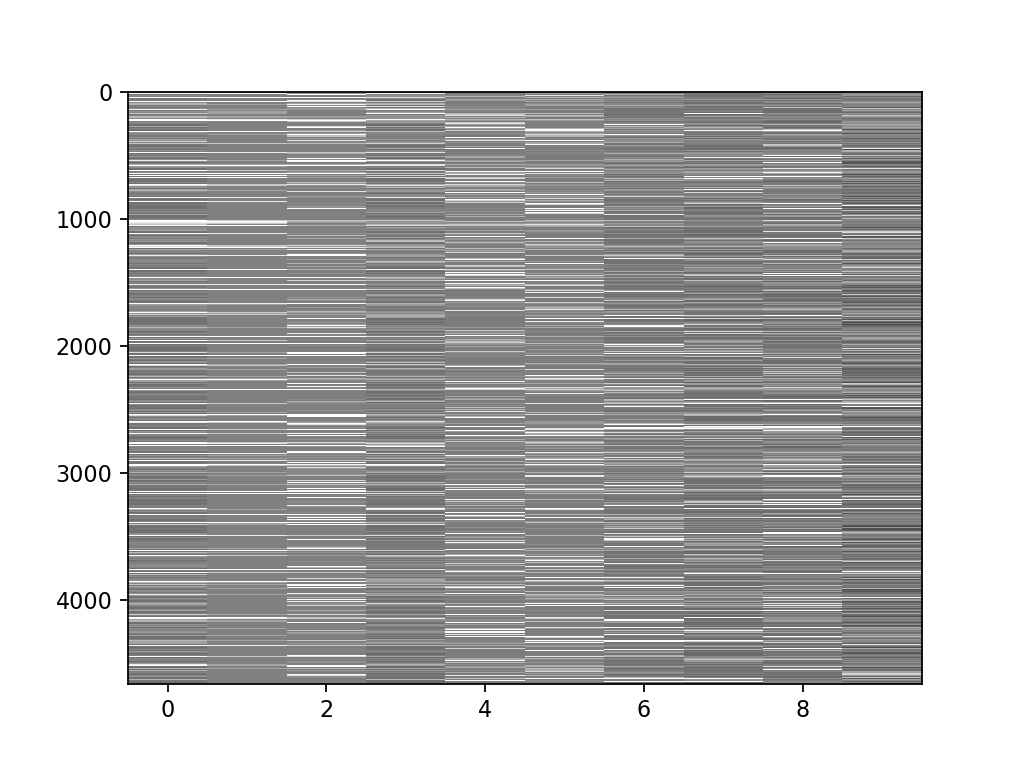

In [141]:
f,ax = plt.subplots()
ax.imshow(Xnorm,
          interpolation='nearest',
          vmin=-3.5,
          vmax=3.5,
          cmap=plt.cm.gray
          )
ax.set_aspect('auto')

In [143]:
split_ones = np.where(LM_per_EM>=2)[0]
split_lm_detections = np.where(np.sum(overlap_matrix[split_ones,:],axis=0))[0]

In [144]:
weights = np.ones(overlap_matrix.shape[1])
weights[split_lm_detections]=0

In [145]:
svm = SVC()
out=svm.fit(Xnorm,label,weights)

In [146]:
print(split_ones)

[ 36  40  47  50  55  62  78  80  95 100 103 111 112 113 117 135 153 179
 191 209 218 223 249 269 293 297 313 326 343 352 355 359 360 361 362 363
 375 378 396 402 403 443 445 456 470 472 478 486 518 567 572 600 601 603
 608 618 619 623 624 637 643 668 669 673 674 679 692 710 739 748 749 761
 790 796]


In [147]:
predgood=out.predict(Xnorm)

In [148]:
svm.score(Xnorm,label,weights)

0.96247779751332152

In [149]:
overlap_matrix.shape

(803, 4658)

In [222]:
overlap_matrix[EM_edge==False,:].shape

(769, 4658)

<IPython.core.display.Javascript object>


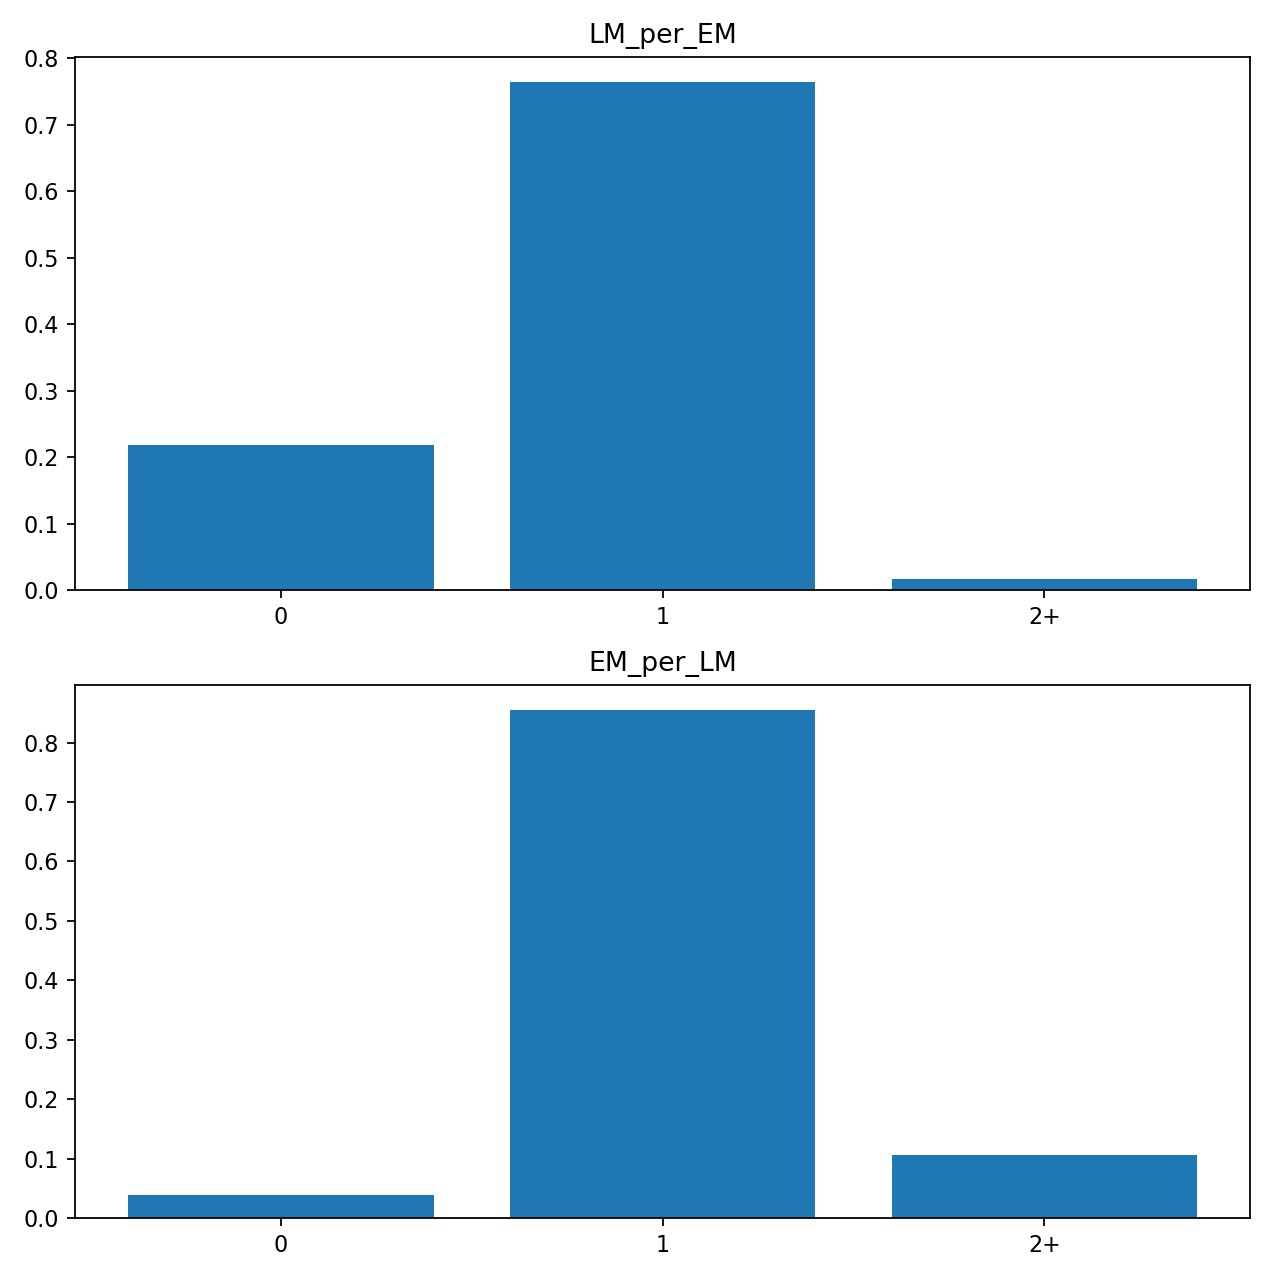

In [258]:
overlap_cut = overlap_matrix[:,predgood]
LM_per_EM = np.sum(overlap_cut[EM_edge==False,:],axis=1)
EM_per_LM = np.sum(overlap_matrix[:,predgood & (LM_edge==False)],axis=0)
f,ax = plt.subplots(2,1,figsize=(8,8))
countsLM,edges = np.histogram(LM_per_EM,bins=[0,1,2,3],normed=True)
ax[0].bar(edges[:-1],countsLM)
ax[0].set_title('LM_per_EM')
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(['0','1','2+'])
countsEM,edges = np.histogram(EM_per_LM,bins=[0,1,2,3],normed=True)
ax[1].bar(edges[:-1],countsEM)
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(['0','1','2+'])
ax[1].set_title('EM_per_LM')
f.tight_layout()

In [259]:
countsLM,countsEM

(array([ 0.21846554,  0.76462939,  0.01690507]),
 array([ 0.03816794,  0.85496183,  0.10687023]))

In [260]:
len(LM_annotations)

4658

In [261]:
false_pos = (label==0) & (predgood==1) & (LM_edge==False)
true_pos = (label ==1) & (predgood==1) & (LM_edge==False)
false_neg = (label == 1) & (predgood==0) & (LM_edge==False)

In [262]:
np.sum(false_pos),np.sum(true_pos),np.sum(false_neg)

(20, 507, 178)

In [307]:
link=""
for k,al in enumerate(LM_annotations):
    if false_neg[k]==1:
        area = al['areas'][0]
        z=area['z']
        xy = np.mean(area['global_path'],axis=0)
        state.position.voxelCoordinates=[xy[0],xy[1],z]
        link += """<a href="%s">%s</a> """%(neuroglancer.to_url(state,ng_server),al['oid'])
display(HTML(link))

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
vol[prop.bbox[0]:prop.bbox[3]+1,prop.bbox[1]:prop.bbox[4]+1,prop.bbox[2]:prop.bbox[5]+1]

In [ ]:
stack = 'Deconvolved_STIDAPI_1_LEILA'
renderapi.stack.set_stack_state(stack, 'COMPLETE',render=render)

In [117]:
controversial_oids="""565
572
791
871
895
925
927
987
1117
1135
1243
1269
1295
1483
1499
1507
1525
1539
1577
1693
1701
1791
1883
1891
2001
2055
2059
2129
2133
2186
2234
2270
2350
2418
2420
2424
2488
2494
2544
2566
2822"""
controversial_oids=controversial_oids.split('\n')

In [126]:
import shutil
synaptogram_folder = "/Users/forrestc/Synaptograms_v2/"
to_send_folder = "/Users/forrestc/To_Kristina_Richard"
if not os.path.isdir(to_send_folder):
    os.makedirs(to_send_folder)       
for ann in controversial_oids:
    from_file = os.path.join(synaptogram_folder,ann+".png")
    to_file = os.path.join(to_send_folder,ann+".png")
    try:
        shutil.copyfile(from_file,to_file)
    except:
        pass

In [121]:
 shutil.copyfile?